In [1]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from load_data import load_data
from model import init_model

from rsl_depth_completion.conditional_diffusion.pipeline_utils import (
    get_ds_kwargs,
    setup_train_pipeline,
)

from rsl_depth_completion.conditional_diffusion.pipeline_utils import (
    create_tracking_exp,
)
from rsl_depth_completion.conditional_diffusion.img_utils import plot_sr_samples
from rsl_depth_completion.conditional_diffusion.img_utils import center_crop

from rsl_depth_completion.conditional_diffusion.utils import print_metrics

torch.backends.cudnn.benchmark = True

In [2]:
import json
from kbnet.kbnet_model import KBNetModel
from argparse import Namespace
from kbnet.net_utils import OutlierRemoval
from kbnet.transforms import Transforms
from kbnet import eval_utils
from kbnet_utils import KBnetPredictor

args = Namespace(**json.load(open('kbnet_val_params.json', 'r')))
kbnet_predictor = KBnetPredictor(args=args)

In [3]:
logdir_name = "debug"

out_dir = f"/tmp/{logdir_name}"
os.makedirs(out_dir, exist_ok=True)
# logdir_name = "standalone_trainer"
cfg, train_logdir = setup_train_pipeline(logdir_name, use_ssl=True)
cfg.disabled = False
cfg.input_res = 256
cfg.unets_output_res = [64, 256]
cfg.only_super_res = True
cfg.use_triplet_loss = True
cfg.batch_size = 1
cfg.other_tags = ["debug"]

experiment = create_tracking_exp(cfg)

ds_kwargs = get_ds_kwargs(cfg)

ds, train_dataloader, val_dataloader = load_data(
    ds_name=cfg.ds_name, do_overfit=cfg.do_overfit, cfg=cfg, **ds_kwargs
)
x = ds[0]
overfit_batch = torch.utils.data.default_collate([x] * cfg.batch_size)
eval_batch = overfit_batch

# tmp, as eval_batch is not loaded from dataset
# eval_batch = ds.eval_batch
# eval_batch["rgb"] /= 255.0
# eval_batch["sdm"] *= ds.ds.max_depth
# eval_batch["gt"] = (center_crop(eval_batch["gt"], (256, 256), channels_last=False))

print(x["cond_img"].shape)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kirilllzaitsev/rsl-depth-completion/8ebd2c7d1285440392caaa850883c66a

2023-06-08 22:10:08.929102: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-08 22:10:08.952638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with th

torch.Size([1, 256, 256])


In [63]:
from rsl_depth_completion.conditional_diffusion.custom_trainer_ssl import (
    ImagenTrainer as ImagenTrainerSSL,
)

cfg.use_super_res = True
unets, model = init_model(experiment, ds_kwargs, cfg, logdir_name)
trainer_kwargs = dict(
    imagen=model,
    use_lion=False,
    lr=1e-4,
    max_grad_norm=5e2,
    # fp16=cfg.fp16,
    fp16=False,
    use_ema=False,
    accelerate_log_with="comet_ml",
    accelerate_project_dir="logs",
)
trainer = ImagenTrainerSSL(**trainer_kwargs)
model_path = '/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/models/plain_centerline_7375-unet-2-last.pt'
# model_path = "./logs/standalone_trainer/121_cfg.exp_targets=['only-sr', 'lowres-as-rescaled-256']/unet-2-last.pt"
trainer.load(
    model_path,
    only_model=True,
)
# trainer.pose_model.eval()
print("loaded")

Using NullUnet as base unet


COMET ERROR: We failed to read file model_params.json for uploading.
Please double-check the file path and permissions


loading saved imagen at version 1.25.4, but current package version is 1.25.2
loaded


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

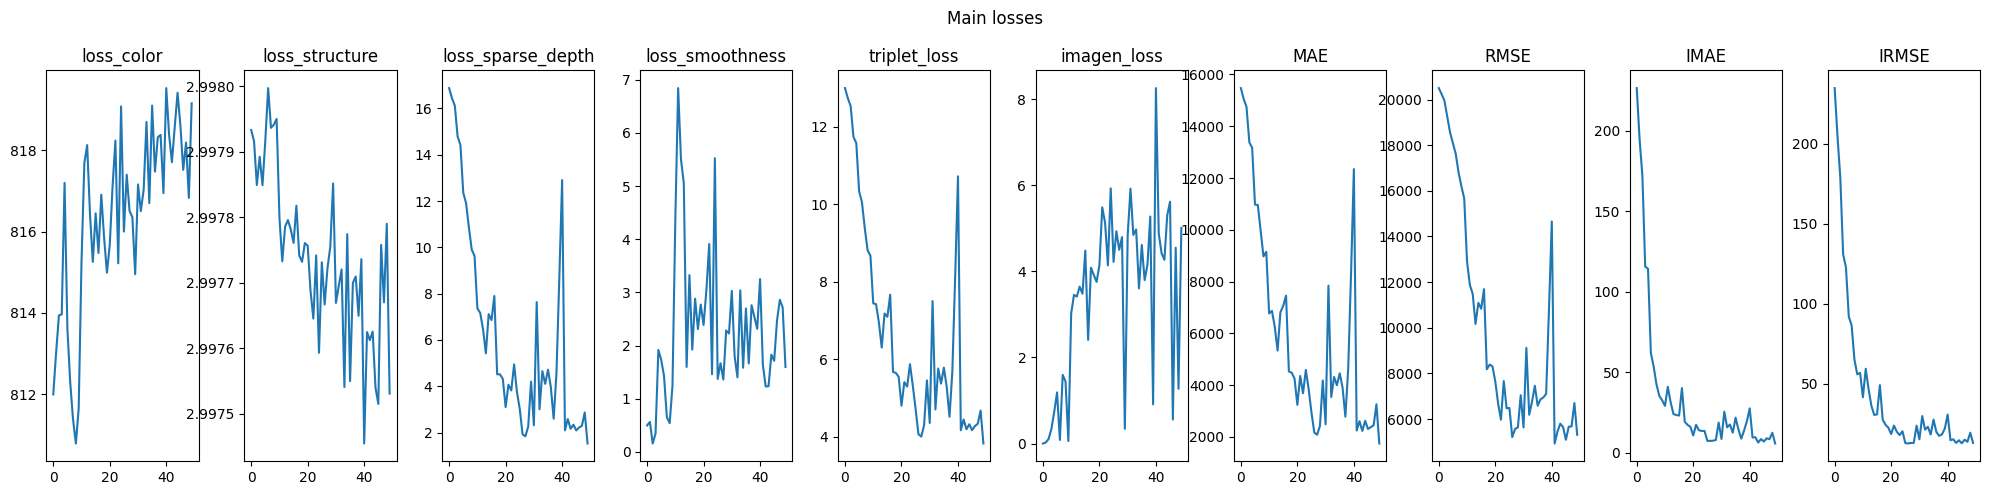

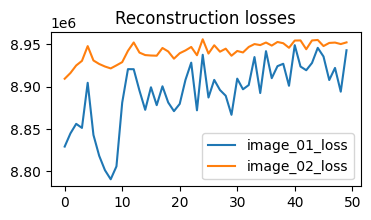

Evaluation results (trainer)
     MAE      RMSE      iMAE     iRMSE
5912.102  9812.061    33.928    43.063
     +/-       +/-       +/-       +/-
3841.481  4820.343    47.369    49.177


In [64]:
from rsl_depth_completion.conditional_diffusion.ssl_utils import (
    calc_error_to_gt,
    plot_losses,
)
from rsl_depth_completion.models.benchmarking.calibrated_backprojection_network.kbnet import (
    eval_utils,
)
from tqdm.auto import tqdm

global_step = 0
batch_size = train_dataloader.batch_size
unet_idx = 2
losses = []
rec_losses = {
    "image_01_loss": [],
    "image_02_loss": [],
}
losses = {
    "loss_color": [],
    "loss_structure": [],
    "loss_sparse_depth": [],
    "loss_smoothness": [],
    "triplet_loss": [],
    "imagen_loss": [],
    "MAE": [],
    "RMSE": [],
    "IMAE": [],
    "IRMSE": [],
}
output_depths = []
parameters_pose_model = list(trainer.pose_model.parameters())
parameters_depth_model = list(trainer.parameters())
depth_grads = {k: [] for k in range(len(parameters_depth_model))}
pose_grads = {k: [] for k in range(len(parameters_pose_model))}

validity_map_depth = torch.where(
    eval_batch["sdm"] > 0, torch.ones_like(eval_batch["sdm"]), eval_batch["sdm"]
).bool()

num_epochs = 50
# plot_epochs = [num_epochs // 2, num_epochs - 1]
plot_epochs = [num_epochs - 1]

progress_bar = tqdm(range(num_epochs), desc="Epoch")
for epoch in progress_bar:
    # progress_bar.set_description(f"Unet {unet_idx}\tEpoch {epoch}")
    images = eval_batch["input_img"]
    text_embeds = eval_batch["text_embed"]
    cond_images = eval_batch["cond_img"]

    forwards_kwargs = dict(
        images=images,
        text_embeds=text_embeds,
        cond_images=cond_images,
        unet_number=unet_idx,
        max_batch_size=cfg.max_batch_size,
        # use_max_times=True
    )

    adj_imgs = eval_batch["adj_imgs"]

    ssl_kwargs = dict(
        image0=eval_batch["rgb"],
        image1=adj_imgs[:, 0],
        image2=adj_imgs[:, 1],
        filtered_sparse_depth0=eval_batch["sdm"],
        filtered_validity_map_depth0=validity_map_depth,
        intrinsics=eval_batch["intrinsics"],
        rec_losses=rec_losses,
        losses=losses,
    )
    forwards_kwargs.update(ssl_kwargs)

    loss, output_depth = trainer(**forwards_kwargs)
    progress_bar.set_postfix(loss=loss)

    for i in range(len(parameters_depth_model)):
        if parameters_depth_model[i].grad is not None:
            depth_grads[i].append(
                torch.sum(torch.abs(parameters_depth_model[i].grad)).item()
            )
    for i in range(len(parameters_pose_model)):
        if parameters_pose_model[i].grad is not None:
            pose_grads[i].append(
                torch.sum(torch.abs(parameters_pose_model[i].grad)).item()
            )

    trainer.update(unet_number=unet_idx)

    mae, rmse, imae, irmse = calc_error_to_gt(output_depth, eval_batch["gt"])

    losses["MAE"].append(mae.item())
    losses["RMSE"].append(rmse.item())
    losses["IMAE"].append(imae.item())
    losses["IRMSE"].append(irmse.item())

    global_step += 1

    for stats in [losses, rec_losses]:
        for k, v in stats:
            experiment.log_metric(f"step/{k}", v[-1], step=global_step)

    output_depths.append(output_depth)

    if epoch in plot_epochs:
        plot_losses(losses, rec_losses)

    # if epoch == 3:
    #     break
print_metrics(
    losses["MAE"], losses["RMSE"], losses["IMAE"], losses["IRMSE"], comment="trainer"
)

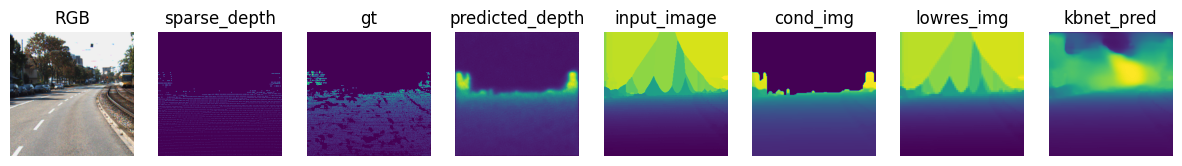

Evaluation results (trainer)
     MAE      RMSE      iMAE     iRMSE
1745.438  5312.724     5.789    13.141
     +/-       +/-       +/-       +/-
   0.000     0.000     0.000     0.000
Evaluation results (kbnet)
     MAE      RMSE      iMAE     iRMSE
 275.677   978.174     0.658     1.012
     +/-       +/-       +/-       +/-
   0.000     0.000     0.000     0.000
Saving to /tmp/fig_0.png


In [65]:
from rsl_depth_completion.conditional_diffusion.utils import plot_full_prediction


figs=plot_full_prediction(
    eval_batch=eval_batch,
    output_depths=output_depths[-1],
    kbnet_predictor=kbnet_predictor,
    # idx_to_use=-1,
)
for idx, fig in enumerate(figs):
    path = f"/tmp/fig_{idx}.png"
    print(f"Saving to {path}")
    fig.savefig(path)
# print_metrics(mae_trainer, rmse_trainer, imae_trainer, irmse_trainer)

{0: [], 876: [333.6453857421875, 515.9652099609375, 872.6293334960938, 1934.9345703125, 2778.90576171875, 1356.9320068359375, 1184.11083984375, 179.3865509033203, 2541.793701171875, 7677.03857421875, 5719.3896484375, 3078.98388671875, 722.245849609375, 1818.3470458984375, 4311.7626953125, 9923.390625, 7683.837890625, 2083.157470703125, 1042.8536376953125, 2849.075439453125, 1495.8106689453125, 12537.224609375, 5708.87109375, 8086.46630859375, 7597.58203125, 6601.80322265625, 4292.6298828125, 905.3258666992188, 4982.3193359375, 8836.431640625, 1820.129150390625, 17482.9140625, 8772.6259765625, 6161.31005859375, 8508.232421875, 7183.0234375, 10130.341796875, 1881.109619140625, 13535.751953125, 17590.9609375, 23102.1640625, 2993.18896484375, 10352.8857421875, 10082.0078125, 9572.890625, 10225.240234375, 4858.01025390625, 5452.2783203125, 5302.4384765625, 4027.4697265625], 780: [44.277557373046875, 80.44621276855469, 133.65640258789062, 228.21347045898438, 379.61492919921875, 508.649597167

/opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{16: [], 20: [50.622066497802734, 10.910400390625, 0.20399907231330872, 1.6606016159057617, 2.1194756031036377, 0.5187783241271973, 2.4228219985961914, 28.22545623779297, 0.38338932394981384, 3.033539056777954, 1.3797190189361572, 0.3011871576309204, 1.194887399673462, 2.035914421081543, 0.532874584197998, 1.295360803604126, 0.821078896522522, 0.24962903559207916, 0.8907161951065063, 3.50630521774292, 0.8397664427757263, 2.94935941696167, 0.1429564207792282, 0.7020576000213623, 0.7228794693946838, 7.009984970092773, 32.86237335205078, 1.149113416671753, 0.6451396942138672, 0.8656137585639954, 1.0464835166931152, 1.8433825969696045, 11.22239875793457, 0.5387601852416992, 0.8750824928283691, 0.45901504158973694, 1.0867702960968018, 4.310239315032959, 0.3038247525691986, 0.4602898955345154, 0.8647676706314087, 0.9856325387954712, 0.6238641738891602, 11.359712600708008, 0.4527547359466553, 1.4968435764312744, 0.4969389736652374, 22.935802459716797, 3.4619922637939453, 28.382089614868164], 

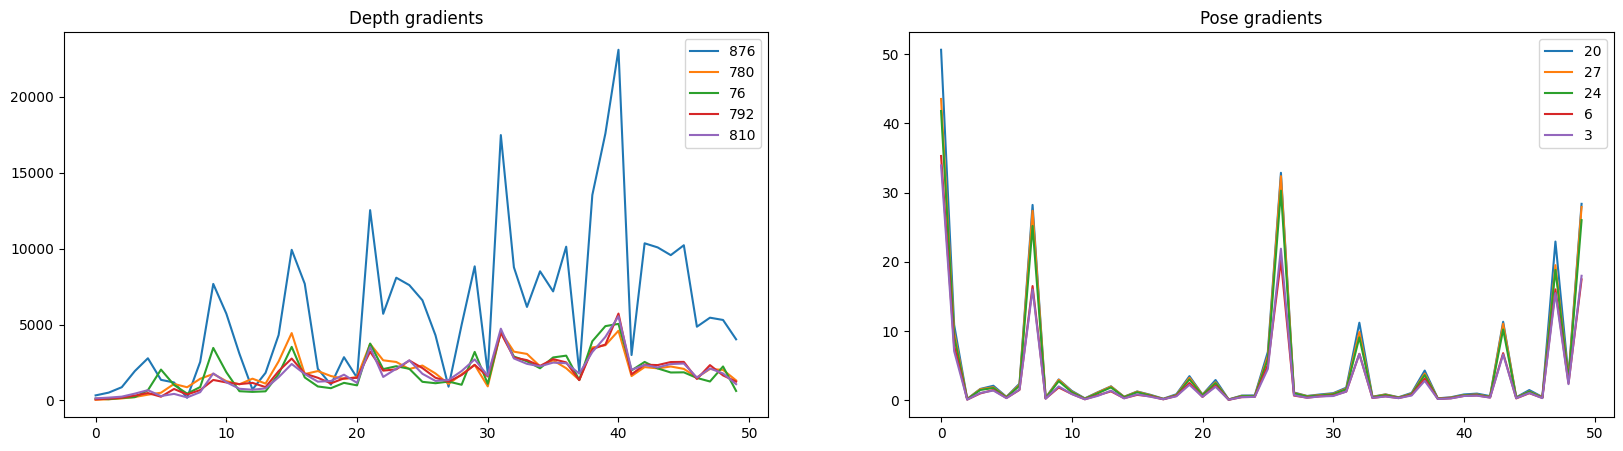

In [66]:
from rsl_depth_completion.conditional_diffusion.ssl_utils import plot_grads
plot_grads(depth_grads, pose_grads, topk=5, bottomk=None)
# plot_grads(depth_grads, pose_grads, topk=None, bottomk=5)

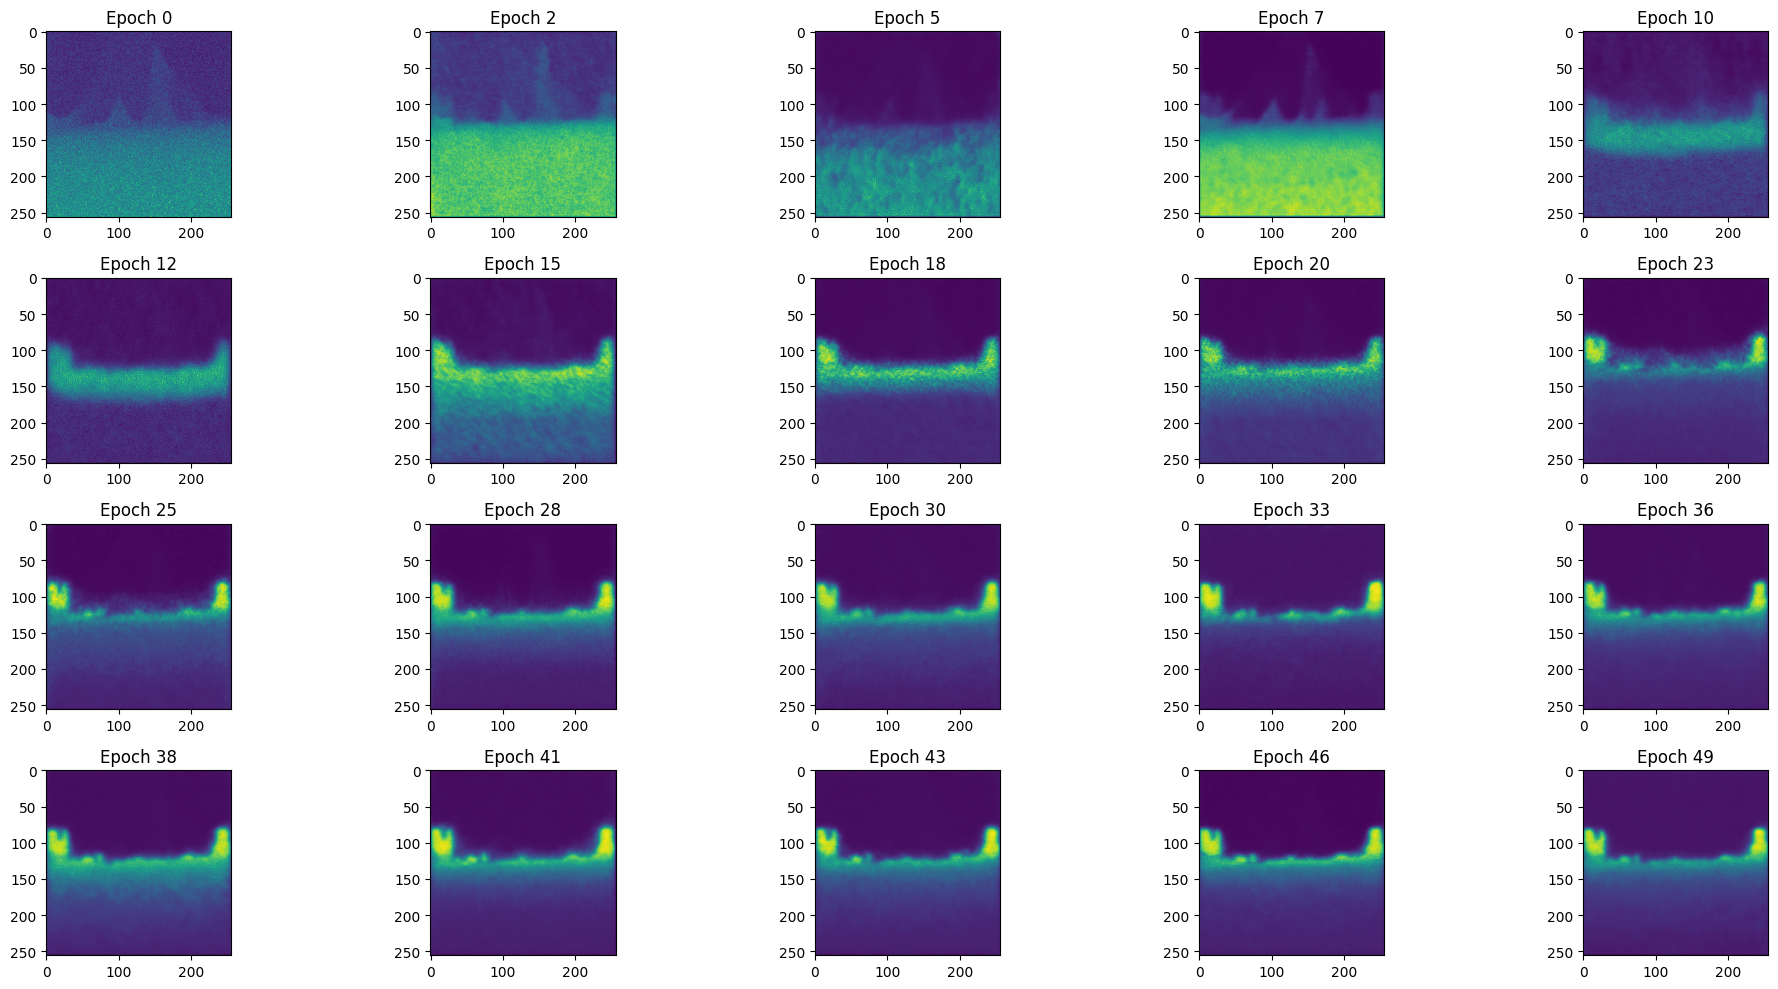

In [67]:
import numpy as np

pred_ckpts = np.linspace(0, len(output_depths)-1, 20).astype(int)
fig, axs = plt.subplots(len(pred_ckpts) // 5, 5, figsize=(20, 10))
for i, ckpt in enumerate(pred_ckpts):
    pred = output_depths[ckpt][-1].detach().cpu().numpy().squeeze()
    # pred = trainer.min_predict_depth / (
    #                 pred + trainer.min_predict_depth / trainer.max_predict_depth
    #             )
    axs[i // 5, i % 5].imshow(pred)
    axs[i // 5, i % 5].set_title(f"Epoch {ckpt}")
plt.tight_layout()
plt.show()

In [68]:
from rsl_depth_completion.conditional_diffusion.train_imagen_loop import sample

unet_idx = 2
start_image_or_video = eval_batch["lowres_img"]
# trainer.imagen.noise_schedulers[unet_idx-1].num_timesteps = 600
samples_lowres = sample(
    cfg,
    trainer,
    out_dir,
    eval_batch,
    1,
    start_at_unet_number=unet_idx,
    start_image_or_video=start_image_or_video,
    stop_at_unet_number=unet_idx + 1,
    experiment=experiment,
)

unet 1 has not been trained
when sampling, you can pass stop_at_unet_number to stop early in the cascade, so it does not try to generate with untrained unets


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

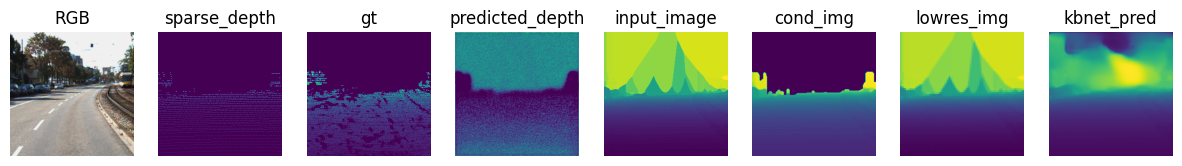

Evaluation results (trainer)
     MAE      RMSE      iMAE     iRMSE
18783.484  22969.848       inf       inf
     +/-       +/-       +/-       +/-
   0.000     0.000       nan       nan
Evaluation results (kbnet)
     MAE      RMSE      iMAE     iRMSE
 275.677   978.174     0.658     1.012
     +/-       +/-       +/-       +/-
   0.000     0.000     0.000     0.000


/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/models/benchmarking/calibrated_backprojection_network/kbnet/eval_utils.py:81: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((1.0 / tgt) - (1.0 / src)))
/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/models/benchmarking/calibrated_backprojection_network/kbnet/eval_utils.py:65: RuntimeWarning: divide by zero encountered in divide
  return np.sqrt(np.mean(((1.0 / tgt) - (1.0 / src)) ** 2))
/opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[<Figure size 1500x500 with 8 Axes>]

In [69]:
plot_full_prediction(
    eval_batch=eval_batch,
    output_depths=samples_lowres[0],
    kbnet_predictor=kbnet_predictor,
    # idx_to_use=-1,
)

0.0 1.0


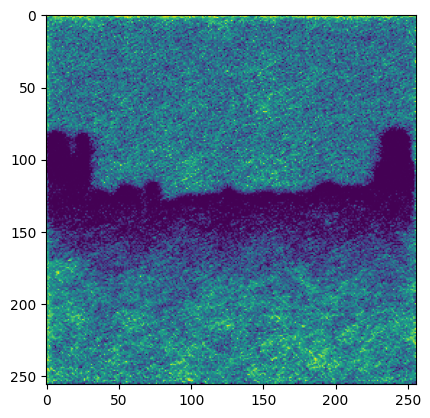

In [13]:
sample_pred = samples_lowres[0][-1].detach().cpu().numpy().squeeze()
sample_pred = trainer.min_predict_depth / (
                sample_pred + trainer.min_predict_depth / trainer.max_predict_depth
            )
print(sample_pred.min(), sample_pred.max())
plt.imshow(sample_pred)

In [105]:
for (k,vs) in (losses.items()):
    for idx, v in enumerate(vs):
        experiment.log_metric(f"step/{k}", v, step=idx)

In [106]:
for idx, fig in enumerate(figs):
    experiment.log_figure(figure_name=f"preds_{idx}", figure=fig)

In [ ]:
experiment.end()

In [ ]:
# from collections import defaultdict
# from functools import partial
# from kbnet.kbnet_model import KBNetModel

# from rsl_depth_completion.conditional_diffusion.custom_imagen_pytorch_ssl import exists
# from rsl_depth_completion.conditional_diffusion.custom_trainer_ssl import cast_torch_tensor, split_args_and_kwargs

# unet_number = trainer.validate_unet_number(unet_idx)
# trainer.validate_and_set_unet_being_trained(unet_number)
# trainer.set_accelerator_scaler(unet_number)

# assert (
#     not exists(trainer.only_train_unet_number)
#     or trainer.only_train_unet_number == unet_number
# ), f"you can only train unet #{trainer.only_train_unet_number}"

# total_loss = 0.0
# output_depths = []
# trainer.min_predict_depth = 1.5
# trainer.max_predict_depth = 100
# kwargs={**forwards_kwargs}
# rec_losses = kwargs.pop("rec_losses", defaultdict(lambda: list()))
# losses = kwargs.pop("losses", defaultdict(lambda: list()))

# kwargs.pop("max_batch_size")
# kwargs.pop("unet_number")

# @partial(cast_torch_tensor, cast_fp16=True)
# def forward(self, *args, unet_number=None, max_batch_size=None, **kwargs):
#     return trainer.imagen(
#                 *args,
#                 unet=trainer.unet_being_trained,
#                 unet_number=unet_number,
#                 **kwargs,
#             )
    
# trainer.pose_optimizer.zero_grad()
# for chunk_size_frac, (chunked_args, chunked_kwargs) in split_args_and_kwargs(
#     *[], split_size=1, **kwargs
# ):
#     with trainer.accelerator.autocast():
#         image0 = chunked_kwargs.pop("image0")
#         image1 = chunked_kwargs.pop("image1")
#         image2 = chunked_kwargs.pop("image2")
#         filtered_sparse_depth0 = chunked_kwargs.pop("filtered_sparse_depth0")
#         filtered_validity_map_depth0 = chunked_kwargs.pop(
#             "filtered_validity_map_depth0"
#         )
#         intrinsics = chunked_kwargs.pop("intrinsics").float()
#         pose01 = trainer.pose_model.forward(image0, image1)
#         pose02 = trainer.pose_model.forward(image0, image2)

#         imagen_loss, output_depth = forward(
#             trainer,
#             *chunked_args,
#             # unet=trainer.unet_being_trained,
#             unet_number=unet_number,
#             **chunked_kwargs,
#         )
#         output_depth0 = torch.sigmoid(output_depth)
#         output_depth0 = trainer.min_predict_depth / (
#             output_depth0 + trainer.min_predict_depth / trainer.max_predict_depth
#         )

#         # Compute loss function
#         triplet_loss, loss_info = KBNetModel.compute_loss(
#             image0=image0.cuda(),
#             image1=image1.cuda(),
#             image2=image2.cuda(),
#             output_depth0=output_depth0.cuda(),
#             sparse_depth0=filtered_sparse_depth0.cuda(),
#             validity_map_depth0=filtered_validity_map_depth0.cuda(),
#             intrinsics=intrinsics.cuda(),
#             pose01=pose01.cuda(),
#             pose02=pose02.cuda(),
#         )

#         loss = triplet_loss
#         # loss = imagen_loss
#         # loss = 0.3*imagen_loss + 0.7*triplet_loss

#         loss = loss * chunk_size_frac

#         image01 = loss_info['image01'].detach().cpu()
#         image02 = loss_info['image02'].detach().cpu()
#         image01_error_summary = torch.sum(
#             torch.mean(torch.abs(image0 - image01), dim=1, keepdim=False)
#         ).item()
#         image02_error_summary = torch.sum(
#             torch.mean(torch.abs(image0 - image02), dim=1, keepdim=False)
#         ).item()
#         # print("image01 reconstruction L1 loss: ", image01_error_summary)
#         # print("image02 reconstruction L1 loss: ", image02_error_summary)
#         rec_losses["image_01_loss"].append(image01_error_summary)
#         rec_losses["image_02_loss"].append(image02_error_summary)

#         loss_keys = [k for k in loss_info.keys() if "loss" in k]
#         for loss_key in loss_keys:
#             # print(f"{loss_key}: {loss_info[loss_key]}")
#             losses[loss_key].append(loss_info[loss_key].item())

#     output_depths.append(output_depth0.detach().cpu())
#     total_loss += loss.item()

#     if trainer.training:
#         trainer.accelerator.backward(loss)
#     print(trainer.pose_model.parameters()[0].grad)
#     print(next(trainer.parameters()).grad)
